## 1. Make ROCs and Annotate

In [1]:
# Load libraries and dataset
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set(style='ticks', color_codes=True)

from random import sample
from os.path import isfile

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

# Load the dataset
data_path = './datasets/Mushroom_Dataset.csv'

df = pd.DataFrame()

if isfile(data_path):
    df = pd.read_csv(data_path)
else:
    print("Dataset not found. Please check that the dataset exists and the path is correct.")
    
df.head()

/home/will/miniconda3/envs/AML/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [2]:
# Check data

# Duplicates? (Nope)
df['duplicate'] = df.duplicated()

if len(df[df['duplicate'] == True]) > 0:
    print(df[df['duplicate'] == True])
    
    dups = df[df['duplicate'] == True].index
    df.drop(dups, inplace=True)
    
df.drop(columns='duplicate', inplace=True)

# Nulls? (Nope)
df['null'] = df.isnull().any()

if len(df[df['null'] == True]) > 0:
    print(df[df['null'] == True])
    
    nu = df[df['null'] == True].index
    
df.drop(columns='null', inplace=True)

# The stalk root has a '?' class, but it's huge so I don't want to replace it with the mode.
# Might drop later to see if that helps the models.
# (Later) Default parameters on the models get close to 100% w/ the missing data, so . . . I'm going to leave it.
# (More-later) Dropping this column is actually better for this assignment as it reduces the accuracy of the models a bit
#df.drop(columns='stalk-root', inplace=True)


In [3]:
# Discretize the data

# Taken from module 3 notebook
def encode_onehot(_df, f):
    _df2 = pd.get_dummies(_df[f], prefix='', prefix_sep='').max(level=0, axis=1).add_prefix(f+' - ')
    df3 = pd.concat([_df, _df2], axis=1)
    df3 = df3.drop([f], axis=1)
    return df3

# all data is nominal and none of it is derived, so let's onehot encode everything except 
# for mushroom class (dep. var.)
df_o = df.copy()
for col in df.columns:
    # don't descretize our dependent variable
    if col == 'class':
        continue
    df_o = encode_onehot(df_o, col)
    
df_o.head()

,class,cap-shape - b,cap-shape - c,cap-shape - f,cap-shape - k,cap-shape - s,cap-shape - x,cap-surface - f,cap-surface - g,cap-surface - s,...,population - s,population - v,population - y,habitat - d,habitat - g,habitat - l,habitat - m,habitat - p,habitat - u,habitat - w
0,p,0,0,0,0,0,1,0,0,1,...,1,0,0,0,0,0,0,0,1,0
1,e,0,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,e,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,p,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,e,0,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [4]:
# Get models and data ready

"""# Only way I could get SVMs to not figure out the mushrooms
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
"""

# Divide data up
x = df_o.loc[:, df_o.columns != 'class'].values
y = df_o.loc[:, df_o.columns == 'class'].values.ravel()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.98, random_state=None)

# Decision Tree Classifiers
dts = {}
for md in range(2, 6):
    for msl in [20, 15, 10, 5, 1]:
        dts[(md, msl)] = DecisionTreeClassifier(max_depth=md, min_samples_leaf=msl)
    
# Random Forest Classifiers
rfs = {}
for md in range(2, 6):
    for msl in [20, 15, 10, 5, 1]:
            rfs[(md, msl)] = RandomForestClassifier(n_estimators=12, max_depth=md, 
                                                         min_samples_leaf=msl)

# RBF SVM Classifiers
rbf_C = [x/1000 for x in range(100, 1100, 100)]
rbfs = {}
for c in rbf_C:
    rbfs[(c)] = SVC(C=c)

# Logistic Regression Classifiers
lrs = {}
lr_C = [x/10000 for x in range(5, 1000, 100)]
for c in lr_C:
    lrs[(c)] = LogisticRegression(penalty='l1', solver='liblinear',
                                  class_weight='balanced', C=c, 
                                  multi_class='auto')

Decision tree


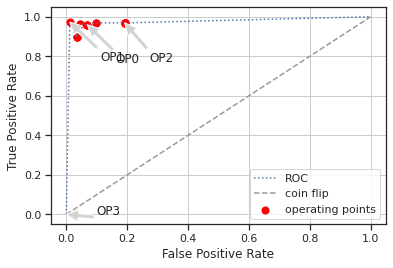

Random forest


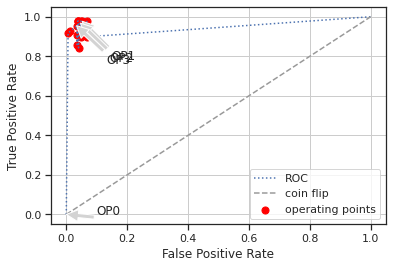

RBF SVM


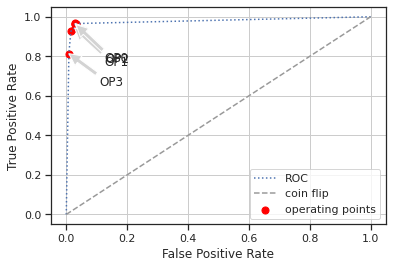

Linear Regression


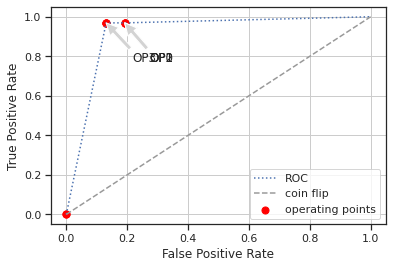

In [5]:
# Display OP

# Taken from module 4 notebook
def annot(opi, x, y):
    plt.annotate(f"OP{opi}", xy=(x, y), xytext=(.90*x+.1, .80*y), arrowprops=dict(facecolor='lightgray', shrink=1))

# Collect data for ROC
# Adapted from module 4 notebook
def collect(model_set, toss=False, verbose=False):
    FPR, TPR = [], []
    for model in model_set:
        _model = model_set[model]
        pipe_lr = make_pipeline(StandardScaler(), _model)
        pipe_lr.fit(x_train, y_train)
        y_pred = pipe_lr.predict(x_test)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        pd = tp / (tp+fn)
        pf = fp / (fp+tn)
        
        # models are too good
        if toss and pf == 0.0:
            continue
        
        TPR += [pd]
        FPR += [pf] 
        
        if verbose:
            print(f'Test Accuracy= {pipe_lr.score(x_test, y_test):.3f}, params={model}, TPR {TPR[-1]:.3f}, FPR {FPR[-1]:.3f}')
        
    return FPR, TPR

# adapted from module 4 notebook
def ROC(FPR: list, TPR: list):
    # Sorts the points to display nicely on ROC
    FPR_TPR = sorted(zip(FPR, TPR))
    FPR, TPR = zip(*FPR_TPR)
    
    fpr = [0.]+list(FPR)+[1.]
    tpr = [0.]+list(TPR)+[1.]

    # Plot
    fig, ax = plt.subplots()
    plt.plot(fpr, tpr, ':', label='ROC')
    plt.scatter(FPR, TPR, 50, color='red', marker='o', label='operating points')
    plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='coin flip')

    # Annotate certain operating points
   
    for idx, op in enumerate(sample(range(0, len(fpr)-1), k=4)):
        annot(idx, fpr[op], tpr[op])

    # Labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()
      
print("Decision tree")        
ROC(*collect(dts))
print("Random forest")
ROC(*collect(rfs))
print("RBF SVM")
ROC(*collect(rbfs, toss=False))
print("Linear Regression")
ROC(*collect(lrs))

## 2. What kind of behavior would you expect to see in Pd – Pf interaction of an ROC curve?

We expect to see a logarithmic-like curve with significant seperation of the ROC from the random function (coin-flip in this case), which demonstrates that the model is properly discriminating between the inputs. We further expect that there is a 'sweet spot' where Pd is maximized and Pf is minimized like OP3 in the Module 4 notebook: 
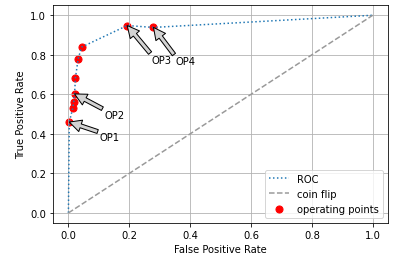

In the above we see that moving to the left from OP3 produces worse Pd but better Pf.

My plots don't produce as beautiful of ROC curves as those given in the Module 4 notebook. The plot for Decision Trees tends to be closest to what we'd expect. The plot for Decision Trees comes closest if we zoom in. The mushroom dataset we are using in this assignment appears to be well curated, and makes for easy/accurate training for True-Positives. Using a SVMs (linear or RBF) I was unable to get any False-Positives.

## 3. Make a selection of the classifier and hyperparameter setting for this problem. 

I misinterpreted the ROC instructions and ended up with ROCs for each, so I'll select a parameter from each.

Each of the classifiers used produced mostly successful results (that is they distinguish posionous from edible pretty well).

Decision Trees and Random Forests both do pretty well with a 'max_depth' of 4 and a 'min_samples_leaf' of 10.
RBF SVMs and Logistic Regressors both do pretty well with a 'C' of 0.5.

In [6]:
# Adapted from module 3 notebook
def train_test(classifier, _x_tr, _x_ts, _y_tr, _y_ts):
    # Train on training data
    model = classifier.fit(_x_tr, _y_tr)
    # Test on training data
    y_pred = model.predict(_x_ts)
    
    tn, fp, fn, tp = confusion_matrix(_y_ts, y_pred).ravel()
   
    pd = tp / (tp+fn)
    pf = fp / (fp+tn)
    
    return pd, pf

output_string = "Model {}, Pd={}, Pf={}"

### Decision Trees

Produce good Pd and okay Pf generally.

In [7]:
dt = DecisionTreeClassifier(max_depth=4, min_samples_leaf=10)

pd, pf = train_test(dt, x_train, x_test, y_train, y_test)

print(output_string.format(dt, pd, pf))

Model DecisionTreeClassifier(max_depth=4, min_samples_leaf=10), Pd=0.8988793328120928, Pf=0.03490909090909091


### Random Forests

Using the same depth and samples from above we produce a forest that works pretty okay (sometimes great but it is a *random* forest classifier). We can improve this by simply uping the number of trees, as shown below.

In [8]:
rf = RandomForestClassifier(n_estimators=12, max_depth=4, min_samples_leaf=10)

pd, pf = train_test(rf, x_train, x_test, y_train, y_test)

print(output_string.format(rf, pd, pf))

rf2 = RandomForestClassifier(n_estimators=12, max_depth=4, min_samples_leaf=10)

pd, pf = train_test(rf2, x_train, x_test, y_train, y_test)

print(output_string.format(rf2, pd, pf))

Model RandomForestClassifier(max_depth=4, min_samples_leaf=10, n_estimators=12), Pd=0.9199895751889497, Pf=0.06351515151515151
Model RandomForestClassifier(max_depth=4, min_samples_leaf=10, n_estimators=12), Pd=0.942402918947094, Pf=0.02327272727272727


### RBF SVMs

I had trouble getting SVMs to produce False Positives, but the below works pretty well.

In [9]:
rbf = SVC(C=1/2)

pd, pf = train_test(rbf, x_train, x_test, y_train, y_test)

print(output_string.format(rbf, pd, pf))

Model SVC(C=0.5), Pd=0.9676830857440709, Pf=0.057212121212121214


### Logistic Regression

Also had some FP problems on this one. 0.5 seems to work pretty well as the C value on both.

In [10]:
lr = LogisticRegression(penalty='l1', solver='liblinear',
                                  class_weight='balanced', C=1/2, 
                                  multi_class='auto')

pd, pf = train_test(lr, x_train, x_test, y_train, y_test)

print(output_string.format(lr, pd, pf))

Model LogisticRegression(C=0.5, class_weight='balanced', penalty='l1',
                   solver='liblinear'), Pd=0.9697680479541309, Pf=0.02909090909090909
